In [1]:
#基本計算
import pandas as pd
import numpy as np
if True:
    name,sheet_name="data.xlsx","main"
    df=pd.concat(pd.read_excel(name,sheet_name =[sheet_name]))#[:100]
    df=df[df["yld"]!="?"].dropna(subset=['smiles',"yld"])
else:
    name,sheet_name="fromScifinder_1-2000_0609.xlsx","Sheet1"
    df=pd.concat(pd.read_excel(name,sheet_name =[sheet_name]))#[:100]
    print(len(df))
    df=df[df["idt"]==True]
    print(len(df))
from steric_ketone_lib import model as mod
param={"cid":"all"}
param["R"]=1.99*10**-3
param["numConfs"]=10
param["minimize"]=True
#df=df.reset_index()
df=mod.new_model_maker(df,param)
df=df[df["solvent"]=="MeOH"][df["c1ccccc1"]==False][df["hetero"]==False]

C:\Users\Sakaguchi Daimon\PycharmProjects - コピー\MSM\steric_ketone_lib\model.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cid"][i]=[_[1] for _ in energies]


NO RADIUS DATA : Br
NO RADIUS DATA : Cl
NO RADIUS DATA : F
NO RADIUS DATA : F
NO RADIUS DATA : Br
NO RADIUS DATA : I


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\2823462043.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[df["solvent"]=="MeOH"][df["c1ccccc1"]==False][df["hetero"]==False]


In [2]:
#def cul_rad_beta(bond_list,conf,const):#結合距離の半値三乗平均立方根
from rdkit import Chem
bond_=[]
for i in df.index:
    bl=[[] for i in range(len(df["mol"][i].GetAtoms()))]
    for bond in df["mol"][i].GetBonds():
        bl[(begin:=bond.GetBeginAtomIdx())].append((end:=bond.GetEndAtomIdx()))
        bl[end].append(begin)
    bond_.append(bl)
df["bond"]=bond_

mfr=[]
for i in df.index:
    mfri=[]
    for cid in df["cid"][i]:
        conf=df["mol"][i].GetConformer(cid)
        mfric=[]
        for atom in df["mol"][i].GetAtoms():
            L=np.array([Chem.rdMolTransforms.GetBondLength(conf, atom.GetIdx(), atom_) for atom_ in df["bond"][i][atom.GetIdx()]])
            mfric.append(np.cbrt(np.average((L/2)**3)))
        mfri.append(np.array(mfric))
    mfr.append(np.array(mfri))
df["mfr"]=mfr

In [3]:
param["radius"]="mfr"
#学習変数値の設定
sr={}
sr["r"]=np.arange(0.5,3+(d:=0.1),d)#np.array([1.2])#np.arange(1.2,1.7,0.1)
sr["r"]=np.round(sr["r"],1)
sr["t"]=np.arange(0,120+(d:=5),d)
sr["t"]=np.round(sr["t"])
#sr["c"]=np.array([1])#np.arange(1000,2000,200)
import itertools
dfl=pd.DataFrame([dict(zip(list(sr),l)) for l in list(itertools.product( *sr.values() ) )]).astype(float)

def culsr(sr):
    sr["t+-"]=np.concatenate([sr["t"],-1*sr["t"]])
    sr["rad+-"]=np.deg2rad(sr["t+-"])
    sr["v"]= [np.array([np.cos(ang),0,np.sin(ang)]) for ang in sr["rad+-"]]
    return sr
sr=culsr(sr)


def disf(df,sr):#距離の計算
    d=[]
    for i in df.index:
        print("disf"+str(i))
        d_=[]
        for cid in df["cid"][i]:
            d__={}
            for v,t in  zip(sr["v"],sr["t+-"]):
                d__[t]=[]
                for conf in df["conf"][i][cid]:
                    if False:
                        a=max(np.inner(v,conf),1.10)
                        d__[t].append(np.linalg.norm(a*v-conf))
                    elif False:
                        a=max(np.inner(v,conf+np.sign(t)*np.array([0,0,1.10])),0)
                        d__[t].append(np.linalg.norm(a*v-conf))
                    else:
                        
                        conf_=conf-np.sign(t)*np.array([0,0,1.10])
                        #print(conf,conf_)
                        a=max(np.inner(v,conf_),0)
                        d__[t].append(np.linalg.norm(a*v-conf_))
            d_.append(d__)
        d.append(d_)
    df["d"]=d
    return df
df=disf(df,sr)
def d3f(df,sr):
    d=[]
    for i in df.index:#d^3の計算
        print("d^3"+str(i))
        d_=[]
        for cid in df["cid"][i]:
            d__={}
            for v,t in  zip(sr["v"],sr["t+-"]):
                d__[t]=np.array(df["d"][i][cid][t])**3
            d_.append(d__)
        d.append(d_)
    df["d^3"]=d
    return df
df=d3f(df,sr)

def dflf(dfl):#体積計算のための予備計算
    import numpy as np
    dfl["r^2"]=dfl["r"]**2
    dfl["r^3"]=dfl["r"]**3
    dfl["4/3*pi*r^3"]=4/3*np.pi*dfl["r"]**3
    return dfl
dfl=dflf(dfl)

def dff(df):#体積計算のための予備計算
    import numpy as np
    if False:
        
        df["R^2"]=[np.array(df["radius"][i])**2 for i in df.index]
        df["R^3"]=[np.array(df["radius"][i])**3 for i in df.index]
    else:
        df["R"]=[np.array(df[param["radius"]][i]) for i in df.index]
        df["R^2"]=[np.array(df[param["radius"]][i])**2 for i in df.index]
        df["R^3"]=[np.array(df[param["radius"]][i])**3 for i in df.index]
    return df
df=dff(df)



disf('main', 0)
disf('main', 26)
disf('main', 27)
disf('main', 44)
disf('main', 45)
disf('main', 47)
disf('main', 48)
disf('main', 54)
disf('main', 60)
disf('main', 68)
disf('main', 70)
disf('main', 73)
disf('main', 76)
disf('main', 81)
disf('main', 85)
disf('main', 105)
disf('main', 106)
disf('main', 107)
disf('main', 108)
disf('main', 124)
disf('main', 125)
disf('main', 132)
disf('main', 133)
disf('main', 134)
disf('main', 138)
disf('main', 139)
disf('main', 142)
disf('main', 143)
disf('main', 147)
disf('main', 148)
disf('main', 149)
disf('main', 150)
disf('main', 151)
disf('main', 152)
d^3('main', 0)
d^3('main', 26)
d^3('main', 27)
d^3('main', 44)
d^3('main', 45)
d^3('main', 47)
d^3('main', 48)
d^3('main', 54)
d^3('main', 60)
d^3('main', 68)
d^3('main', 70)
d^3('main', 73)
d^3('main', 76)
d^3('main', 81)
d^3('main', 85)
d^3('main', 105)
d^3('main', 106)
d^3('main', 107)
d^3('main', 108)
d^3('main', 124)
d^3('main', 125)
d^3('main', 132)
d^3('main', 133)
d^3('main', 134)
d^3('main', 

In [4]:
def volf(df,dfl):#体積計算#遅いから改良する必要あり?#atomlistを作成すれば早くなりそう
    import time
    def sphere(r,r2,r3,R,R2,R3,d,d3):
        if r+R<d:
            return 0
        elif d<abs(r-R):
            return 4/3*np.pi*min(r3,R3)
        return np.pi/12*(d3-6*d*(r2+R2)+8*(r3+R3)-3/d*(r2-R2)**2)
    v=[]
    ti=[]
    for i in df.index:
        ti.append(time.time())
        print(ti[-1]-ti[0])
        v_=[]
        print("volf"+str(i))
        if False:
            R,R2,R3=df["radius"][i],df["R^2"][i],df["R^3"][i]
        else:
            R_,R2_,R3_=df["R"][i],df["R^2"][i],df["R^3"][i]
        
        d,d3=df["d"][i],df["d^3"][i]
        sub=df["sub_atom"][i]
        cids=df["cid"][i]
        for _ in dfl.index:
            r,r2,r3=dfl["r"][_],dfl["r^2"][_],dfl["r^3"][_]
            t=dfl["t"][_]
            v__=[]
            for c,cid in enumerate(cids):
                if param["radius"]=="mfr":
                    R,R2,R3=R_[c],R2_[c],R3_[c]
                else:
                    R,R2,R3=R_,R2_,R3_
                    #print("R",R)
                v___=[]
                for tj in [t,-t]:
                    v___.append(sum([sphere(r,r2,r3,R[atom],R2[atom],R3[atom],d[cid][tj][atom],d3[cid][tj][atom]) for atom in sub]))
                v__.append(v___)
            v_.append(v__)
        v.append(v_)
        
    df["v"]=v
    return df
df=volf(df,dfl)
#np.where((a > 2) & (a < 6), -1, 100))

0.0
volf('main', 0)
0.22476482391357422
volf('main', 26)
2.4185895919799805
volf('main', 27)
5.469261646270752
volf('main', 44)
5.6957807540893555
volf('main', 45)
7.385874032974243
volf('main', 47)
8.7153639793396
volf('main', 48)
10.143870115280151
volf('main', 54)
12.703400611877441
volf('main', 60)
14.890012264251709
volf('main', 68)
16.297266006469727
volf('main', 70)
17.75790810585022
volf('main', 73)
19.002119779586792
volf('main', 76)
19.702937364578247
volf('main', 81)
20.527190685272217
volf('main', 85)
21.227577686309814
volf('main', 105)
22.949684858322144
volf('main', 106)
24.414982080459595
volf('main', 107)
25.800828456878662
volf('main', 108)
27.47495937347412
volf('main', 124)
28.375452756881714
volf('main', 125)
29.93674111366272
volf('main', 132)
30.19725799560547
volf('main', 133)
30.629894495010376
volf('main', 134)
31.09620761871338
volf('main', 138)
31.978386163711548
volf('main', 139)
33.69017577171326
volf('main', 142)
35.18308234214783
volf('main', 143)
35.560

In [ ]:
#df_の定義
df_=df[(df.index!=("main",45))&(df.index!=("main",70))&(df.index!=("main",138))&(df.index!=("main",73))&(df.index!=("main",139))]#&(df.index!=("main",150))][df["solvent"]=="MeOH"][df["c1ccccc1"]==False][df["hetero"]==False]#(df.index!=("main",150))&
print(len(df_))
def dflf(df,dfl):#cを含め、選択性算出
    import math
    from sklearn.metrics import mean_squared_error
    from scipy.optimize import minimize
    yld=[]
    clist=[]
    rmse=[]
    for _ in dfl.index:
        print(_)
        
        def yldf(c):
            yld_=[]
            for i in df.index:
                ene=df["energy"][i]
                v=df["v"][i][_]
                RT=param["R"]*df["temp."][i]
                k=[]
                for j in range(2):
                    #print([(v[cid][j]*c+ene[cid])/RT for cid in df["cid"][i]])
                    try:
                        k.append(sum([np.exp(-(v[cid][j]*c+ene[cid])/RT) for cid in df["cid"][i]]))
                    except:
                        
                        k.append(np.inf)
                if k[0]==k[1]==0: ans=50
                else: ans=k[0]/sum(k)*100
                yld_.append(ans)
            return yld_
        def func(c):
            try: ans=np.sqrt(mean_squared_error(yldf(c),df["yld"]))
            except: print(yldf(c),c)
            return ans
        if dfl["c"][_]=="train":
            result=minimize(func, x0=10, method="Nelder-Mead",tol = 10**-3)
            rmse.append(result.fun)
            yld.append(yldf(result.x))
            clist.append(result.x)
        else:
            yld.append(yldf(dfl["c"][_]))
            rmse.append(func(dfl["c"][_]))
            clist.append(dfl["c"][_])
            #print("yld is "+str(yld))
    dfl["yld"]=yld
    dfl["rmse"]=rmse
    dfl["c"]=clist
    return dfl
dfl["c"]="train"
dfl=dflf(df_,dfl)

#ヒートマップ作成
import matplotlib.pyplot as plt
import seaborn as sns
dfh = pd.DataFrame(data=dfl["rmse"].to_numpy().reshape(len(dfl["r"].drop_duplicates()),len(dfl["t"].drop_duplicates())), 
                   index=dfl["r"].drop_duplicates(), columns=np.round(dfl["t"]).drop_duplicates())
#index=[round(s,2) for s in sr["radius_a"]
plt.figure()
sns.heatmap(dfh,square=True,vmin=15, vmax=25,center=20)
plt.show()
#散布図作成
df_["yldtr"]=list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0]
for i in df_.index:
    plt.annotate(i[1], (df_["yldtr"][i], df_["yld"][i]))
plt.plot(list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0],df_["yld"],"o",color="b",label=None,alpha = 1,linewidth=4)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()
dfl[dfl["rmse"]==dfl["rmse"].min()][["r","t","c","rmse"]]#最適値の変数値

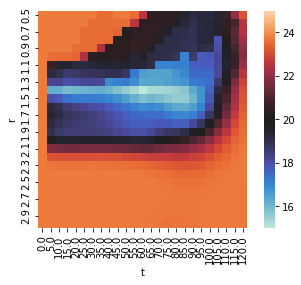

C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\1641705174.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["yldtr"]=list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0]


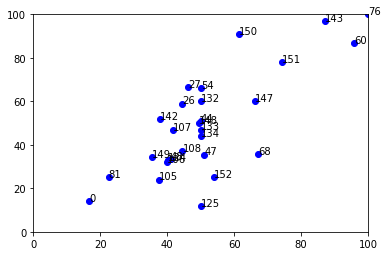

,r,t,c,rmse
237,1.4,60.0,[4141.5],14.981621


In [17]:
#ヒートマップ作成
import matplotlib.pyplot as plt
import seaborn as sns
dfh = pd.DataFrame(data=dfl["rmse"].to_numpy().reshape(len(dfl["r"].drop_duplicates()),len(dfl["t"].drop_duplicates())), 
                   index=dfl["r"].drop_duplicates(), columns=np.round(dfl["t"]).drop_duplicates())
#index=[round(s,2) for s in sr["radius_a"]
plt.figure()
sns.heatmap(dfh,square=True,vmin=15, vmax=25,center=20)
plt.show()
#散布図作成
df_["yldtr"]=list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0]
for i in df_.index:
    plt.annotate(i[1], (df_["yldtr"][i], df_["yld"][i]))
plt.plot(list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0],df_["yld"],"o",color="b",label=None,alpha = 1,linewidth=4)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()
dfl[dfl["rmse"]==dfl["rmse"].min()][["r","t","c","rmse"]]#最適値の変数値

28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276

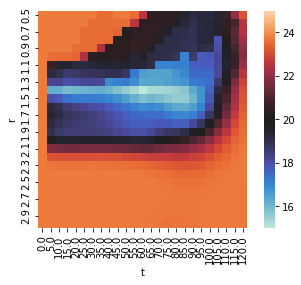

C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["yldtr"]=list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0]


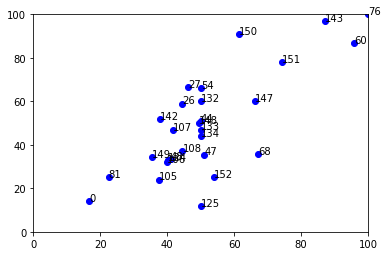

,r,t,c,rmse
237,1.4,60.0,[4141.5],14.981621


In [7]:
#df_の定義
df_=df[(df.index!=("main",45))&(df.index!=("main",70))&(df.index!=("main",138))&(df.index!=("main",73))&(df.index!=("main",139))&(df.index!=("main",85))]#&(df.index!=("main",150))][df["solvent"]=="MeOH"][df["c1ccccc1"]==False][df["hetero"]==False]#(df.index!=("main",150))&
print(len(df_))
def dflf(df,dfl):#cを含め、選択性算出
    import math
    from sklearn.metrics import mean_squared_error
    from scipy.optimize import minimize
    yld=[]
    clist=[]
    rmse=[]
    for _ in dfl.index:
        print(_)
        
        def yldf(c):
            yld_=[]
            for i in df.index:
                ene=df["energy"][i]
                v=df["v"][i][_]
                RT=param["R"]*df["temp."][i]
                T=df["temp."][i]
                k=[]
                for j in range(2):
                    #print([(v[cid][j]*c+ene[cid])/RT for cid in df["cid"][i]])
                    try:
                        #k.append(sum([np.exp(-(v[cid][j]*c+ene[cid])/RT) for cid in df["cid"][i]]))
                        
                        k.append(sum([np.exp(-(v[cid][j]*c/T+ene[cid]/RT)) for cid in df["cid"][i]]))
                    except:
                        print("E="+str(E))
                        k.append(np.inf)
                if k[0]==k[1]==0: ans=50
                else: ans=k[0]/sum(k)*100
                yld_.append(ans)
            return yld_
        def func(c):
            try: ans=np.sqrt(mean_squared_error(yldf(c),df["yld"]))
            except: print(yldf(c),c)
            return ans
        if dfl["c"][_]=="train":
            result=minimize(func, x0=10, method="Nelder-Mead",tol = 10**-1)
            rmse.append(result.fun)
            yld.append(yldf(result.x))
            clist.append(result.x)
        else:
            yld.append(yldf(dfl["c"][_]))
            rmse.append(func(dfl["c"][_]))
            clist.append(dfl["c"][_])
            #print("yld is "+str(yld))
    dfl["yld"]=yld
    dfl["rmse"]=rmse
    dfl["c"]=clist
    return dfl
dfl["c"]="train"
dfl=dflf(df_,dfl)

#ヒートマップ作成
import matplotlib.pyplot as plt
import seaborn as sns
dfh = pd.DataFrame(data=dfl["rmse"].to_numpy().reshape(len(dfl["r"].drop_duplicates()),len(dfl["t"].drop_duplicates())), 
                   index=dfl["r"].drop_duplicates(), columns=np.round(dfl["t"]).drop_duplicates())
#index=[round(s,2) for s in sr["radius_a"]
plt.figure()
sns.heatmap(dfh,square=True,vmin=15, vmax=25,center=20)
plt.show()
#散布図作成
df_["yldtr"]=list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0]
for i in df_.index:
    plt.annotate(i[1], (df_["yldtr"][i], df_["yld"][i]))
plt.plot(list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0],df_["yld"],"o",color="b",label=None,alpha = 1,linewidth=4)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()
dfl[dfl["rmse"]==dfl["rmse"].min()][["r","t","c","rmse"]]#最適値の変数値

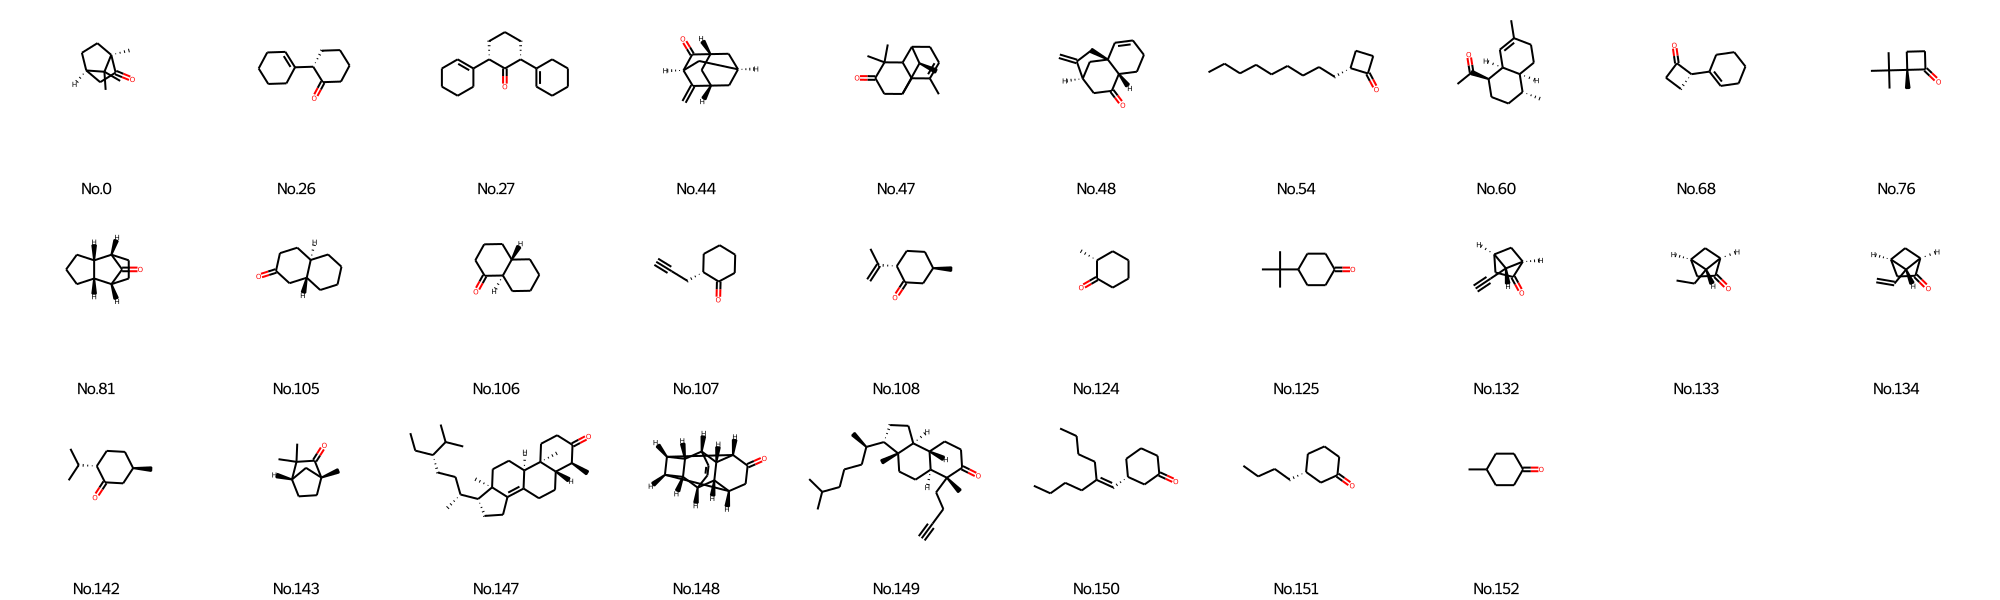

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(name) for name in df_["smiles"]],
                         molsPerRow=10, subImgSize=(200,200),
                         legends=["No."+str(i[1]) for i in df_.index], maxMols = 100)

In [9]:
if False:
    i=("main",150)
    df["v"][i][83]

In [10]:
a=np.deg2rad(85)
np.array([np.cos(a),0,np.sin(a)])
v=np.array([np.cos(a),0,np.sin(a)])
v*1.1
conf=np.array([(df["radius"][i][atom]+0.8,np.linalg.norm(df["conf"][i][0][atom]-v*1.1)) for atom in df["sub_atom"][i]])
conf

array([[2.5       , 3.05877709],
       [2.5       , 3.28577947],
       [2.5       , 4.15654654],
       [2.5       , 2.51053274],
       [2.        , 2.6356612 ],
       [2.        , 1.91573027],
       [2.        , 3.9046394 ],
       [2.        , 3.57229574],
       [2.        , 4.15860614],
       [2.        , 4.74041782],
       [2.        , 3.85227347],
       [2.        , 4.99650066],
       [2.        , 3.45935781],
       [2.        , 2.28075913],
       [2.        , 2.14535637],
       [2.        , 2.86447024]])

In [11]:
1

1

In [12]:
rad=np.array([df["radius"][i][atom] for atom in df["sub_atom"][i]])
rad

array([1.7, 1.7, 1.7, 1.7, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2,
       1.2, 1.2, 1.2])

In [13]:
conf_x=conf[-rad<np.array([c[1] for c in conf])<rad]
conf_x

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
inner=np.inner(conf,v)
inner

In [ ]:
np.array([i*v for i in inner])

In [ ]:
[df["conf"][i][0][atom]-df["radius"][i][atom] for atom in df["sub_atom"][i]]

In [ ]:
df_["energy"][("main",150)]

In [ ]:
plt.plot(list(dfl[dfl["r"]==1][dfl["t"]==110]["yld"])[0],df_["yld"],"o",color="b",label=None,alpha = 1,linewidth=4)
plt.xlim(0,100)
plt.ylim(0,100)
df_["yldtr"]=list(dfl[dfl["r"]==1][dfl["t"]==110]["yld"])[0]
for j,i in enumerate(df_.index):
    plt.annotate(i[1], (list(dfl[dfl["r"]==1][dfl["t"]==110]["yld"])[0][j], df_["yld"][i]))
plt.show()
dfl[dfl["r"]==1][dfl["t"]==110][["r","t","c","rmse"]]

In [ ]:
plt.plot(list(dfl[dfl["r"]==0.8][dfl["t"]==95]["yld"])[0],df_["yld"],"o",color="b",label=None,alpha = 1,linewidth=4)
plt.xlim(0,100)
plt.ylim(0,100)
df_["yldtr"]=list(dfl[dfl["r"]==0.8][dfl["t"]==85]["yld"])[0]
for j,i in enumerate(df_.index):
    plt.annotate(i[1], (list(dfl[dfl["r"]==0.8][dfl["t"]==95]["yld"])[0][j], df_["yld"][i]))
plt.show()

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(name) for name in df_["smiles"]],
                         molsPerRow=10, subImgSize=(200,200),
                         legends=["No."+str(i[1]) for i in df_.index], maxMols = 100)

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(name) for name in df["smiles"]],
                         molsPerRow=10, subImgSize=(200,200),
                         legends=["No."+str(i[1]) for i in df.index], maxMols = 100)

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
i=('main', 150)
print(df.loc[i,"yld"])
name=df["mol"][i]
ci=np.array(df["cid"][i])[np.array(df["energy"][i])==0]
IPythonConsole.drawMol3D(name,confId=int(ci))
df["smiles"][i],df["conf"][i][int(ci)],int(ci)#,df_["CITATION"][i],df_["TITLE"][i],int(ci),df_["mols_rea"][0]

In [ ]:
for i in df[df.index==("main",149)]["energy"]:
    print(i)

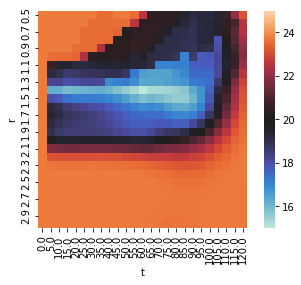

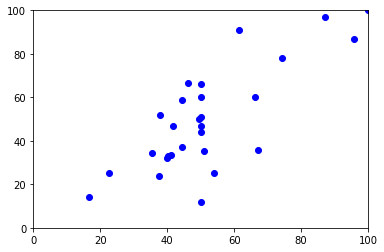

,r,t,c,rmse
237,1.4,60.0,[4141.5],14.981621


In [18]:
#消す
dfh = pd.DataFrame(data=dfl["rmse"].to_numpy().reshape(len(dfl["r"].drop_duplicates()),len(dfl["t"].drop_duplicates())), 
                   index=dfl["r"].drop_duplicates(), columns=np.round(dfl["t"]).drop_duplicates())
#index=[round(s,2) for s in sr["radius_a"]
plt.figure()
sns.heatmap(dfh,square=True,vmin=15, vmax=25,center=20)
plt.show()
#散布図作成
plt.plot(list(dfl[dfl["rmse"]==dfl["rmse"].min()]["yld"])[0],df_["yld"],"o",color="b",label=None,alpha = 1,linewidth=4)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()
dfl[dfl["rmse"]==dfl["rmse"].min()][["r","t","c","rmse"]]#最適値の変数値

('main', 0)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":
C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfl["yld"]=yld
C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfl["rmse"]=rms

237
('main', 27)
237
237
('main', 44)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 47)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 48)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 54)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 60)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 68)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 76)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 81)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 105)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 106)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 107)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 108)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 124)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 125)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 132)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 133)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 134)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 142)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 143)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 147)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 148)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 149)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 150)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 151)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237
('main', 152)
237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":


237


C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\3093614440.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dfl["c"][_]=="train":
C:\Users\Sakaguchi Daimon\AppData\Local\Temp\ipykernel_25892\2171229408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["yldt"]=yldt


(0.0, 100.0)

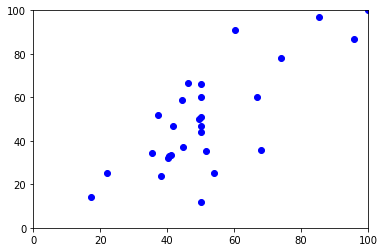

In [19]:
def loo(df,dfl):
    yldt=[]
    for i in df.index:
        dfl["c"]="train"
        print(i)
        dfl=dflf(df[df.index!=i],dfl)
        dfl=dflf(df[df.index==i],dfl[dfl["rmse"]==dfl["rmse"].min()])
        yldt.extend(dfl.iloc[0]['yld'])
    df["yldt"]=yldt
    return df
df_=loo(df_,dfl)
plt.plot(df_["yldt"],df_["yld"],"o",color="b",label=None,alpha = 1,linewidth=4)
plt.xlim(0,100)
plt.ylim(0,100)

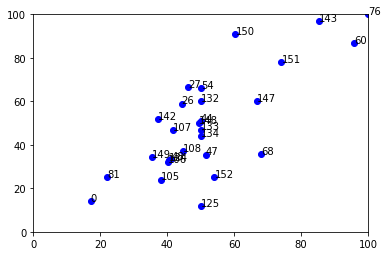

15.29334904037042

In [20]:
from sklearn.metrics import mean_squared_error
for i in df_.index:
    plt.annotate(i[1], (df_["yldt"][i], df_["yld"][i]))
plt.plot(df_["yldt"],df_["yld"],"o",color="b",label=None,alpha = 1,linewidth=4)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()
np.sqrt(mean_squared_error(df_["yldt"],df_["yld"]))